In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [2]:
data = pd.read_csv('../train.csv')
testData = pd.read_csv('../test.csv')


## Here are our corr matrix for feature selection

In [ ]:
#visual correlation matrix
f = plt.figure(figsize=(25,25))
plt.matshow(data.corr(), fignum=f.number)
cb = plt.colorbar()

#correlation matrix to csv
c = data.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so.to_csv('./corr.csv')

#corr matrix of fin chosen set
c = fin_set.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so.to_csv('./finalSetcorr.csv')

In [ ]:
#percentage of missing per column
print((data.count() / len(data)) *100)

#total missing columns
print(data.isna().sum())

#where there is no full bath above ground, 
a = np.where(df['FullBath'].values == 0)
print(data.loc[a])

In [ ]:
#Jason function for scatterplots
sns.set()
cols = ['WoodDeckSF',
'OpenPorchSF',
'EnclosedPorch',
'3SsnPorch',
'ScreenPorch',
'PoolArea']
sns.pairplot(df[cols], size = 2.5)
plt.show();
plt.savefig('pairplot.png',bbox_inches='tight')

### Creates visualization for distributions

In [ ]:
#show distribution of set
sets = ['LotShape',
'Neighborhood',
'HouseStyle',
'Heating',
'CentralAir',
'KitchenQual',
'Functional',
'GarageType',
'GarageQual',
'Fence',
'SaleType',
'SaleCondition']

#Jaye function to count unique values
for c in data.columns[:]:
    if c in sets:
        print('\nCOLUMN: "{}"\n=============================='.format(c))
        print(data[c].value_counts(dropna=False).to_string())
        # only include above columns categorical
        continue

## Features we have chosen to use after feature selection

In [30]:
#variables we chose
chosen = ['LotFrontage','LotArea','LotShape','HouseStyle',
'OverallQual','OverallCond','YearBuilt','YearRemodAdd', 'CentralAir',
'MasVnrArea','1stFlrSF','2ndFlrSF','GrLivArea','Heating',
'BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
'KitchenQual','Fireplaces','GarageType','GarageCars', 'Neighborhood',
'WoodDeckSF','OpenPorchSF','PoolArea', 'Fence','SaleCondition']

#create dataset of chosen
fin_set = data[chosen].copy()
fin_test = testData[chosen].copy()

In [ ]:
c = fin_set.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
so.to_csv('./testcorr.csv')

In [ ]:
fin_set.describe()

### Clean data further, log transformation and feature engineering

In [31]:
fin_set['PoolArea'] = fin_set['PoolArea'].apply(lambda x: 1 if x>0 else 0)
fin_set['Fireplaces'] = fin_set['Fireplaces'].apply(lambda x: 'y' if x>0 else 'n')

In [32]:
fin_set['LotArea'] = np.log(fin_set['LotArea'])
#fin_set['MasVnrArea'] = np.log(fin_set['MasVnrArea'])
#fin_set['2ndFlrSF'] = np.log(fin_set['2ndFlrSF'])
#fin_set['OpenPorchSF'] = np.log(fin_set['OpenPorchSF'])

## Num_Cleaner

Takes in a dataframe and returns only int and floats with na's imputed with mean value

In [5]:
#find numeric columns in given df,replace missing rows with column mean, return dataframe
def num_cleaner (df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    cl_df = pd.DataFrame()

    df2 = df.select_dtypes(include=numerics).copy() #only numeric columns
    nullCols = df2.isnull() #df of T/F, T if null (bool mask)
    means = df2.mean() #series of mean per column

    for c in df2:
        for r in range(0,len(df2)-1):
            if df2[c].iloc[r] and nullCols[c].iloc[r]:
                df2[c].iloc[r] = means[c]

    cl_df = df2.copy() #this will return only numeric features, need to add back type ob features after cleaning/dummify them
    return cl_df

## Dummify dataframe
Find object types and dummify the columns

In [6]:
#dummify object columns and return dataframe
def mass_dummify (df):
    df2 = df.select_dtypes(include=object).copy()
    dum_df = pd.get_dummies(df2) #currently 61 columns, no neighborhoods
    return dum_df

## Lasso Regression Visualization

Given many lambdas (alphas), graph an elastic net function with amount given. 

Only 10 colors available on graph

In [ ]:
#lasso reg vizualization for many lamdas
def lassoReg (alphas, df, target):

    lasso  = Lasso()
    #alphas = np.linspace(0.1,20.1,20)
    lasso.set_params(normalize=False)
    coefs_lasso  = []

    for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(df, target)  
        coefs_lasso.append(lasso.coef_)

    coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = df.columns)  
    #coefs_lasso.head()
    
    plt.rcParams['figure.figsize'] = (20,20)
    for name in coefs_lasso.columns:
        plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
        
        
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'slope values')
    plt.legend(loc=1)

## Elastic Net Visualization
Given many lambdas (alphas), graph an elastic net function with amount given. 

rho = 1 lasso regression, rho = 0 ridge regression.

Only 10 colors available on graph

In [47]:
#elastisc net vizualization graph for many lambdas
def elasticNet (alphas, df, target, rho):

    elasticnet = ElasticNet()
    elasticnet.set_params(normalize=False)
    coefs_model  = []
    #run through many alphas(lambdas)
    for alpha in alphas:
        elasticnet.set_params(alpha=alpha, l1_ratio= rho)
        elasticnet.fit(df, target)  
        coefs_model.append(elasticnet.coef_)

    coefs_model = pd.DataFrame(coefs_model, index = alphas, columns = df.columns)  
    
    #plot all the figures for different lambda
    plt.rcParams['figure.figsize'] = (20,20)
    for name in coefs_model.columns:
        plt.plot(coefs_model.index, coefs_model[name], label=name)
            
    plt.xlabel(r'hyperparameter $\lambda$')
    plt.ylabel(r'slope values')
    plt.legend(loc=1)

C:\Users\conma\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


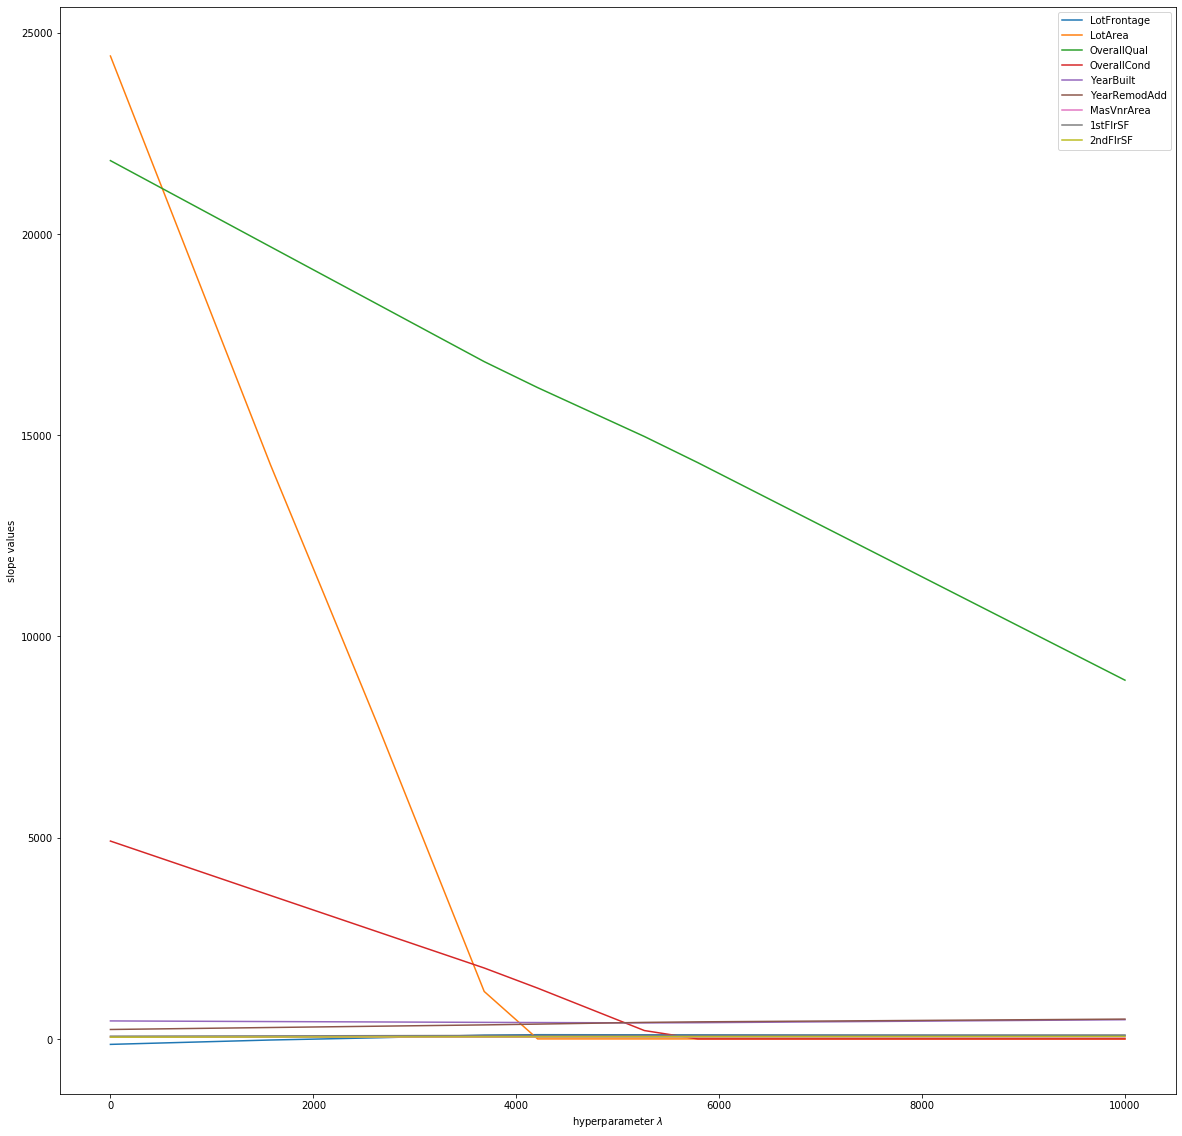

In [72]:
#lambda
alphas = np.linspace(1e-3,1e4,20)
#target
prices = pd.Series(data.SalePrice)
#only num & no NA
cleaned = num_cleaner(fin_set).copy()
#cleaned2 = num_cleaner(data).copy()
#elasticNet visualization for multiple lambda
elasticNet(alphas,cleaned.iloc[:,:9],prices,1) #1 for lasso, 0 for ridge, mixture is elastic net

## Outputs an elastic net model that has been fitted to dataframe and target
rho = 1 is lasso regressoion, rho=0 is ridge regression

In [ ]:
#returns elasticNet based on one lambda
def elasticNetModel (alpha, df, target, rho):
    
    elasticnet = ElasticNet()
    elasticnet.set_params(normalize=False,l1ratio = rho)
    model = elasticnet.fit(df,target)
    return model

### Clean code using functions

In [33]:
num_clean = num_cleaner(fin_set).copy()
ob_clean = mass_dummify(fin_set).copy()
#combine num & ob dataset for Train
cl_df = pd.concat([num_clean,ob_clean],axis=1)

C:\Users\conma\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
df1 = num_cleaner(fin_test)
df2 = mass_dummify(fin_test)
#combine Test sets
cl_test = pd.concat([df1,df2],axis = 1)

C:\Users\conma\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Multi-linear regression model

In [8]:
#multi-linear regression
X_add_const = sm.add_constant(cl_df)
y = data.SalePrice
ols = sm.OLS(y, X_add_const)
model = ols.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     107.3
Date:                Mon, 02 Mar 2020   Prob (F-statistic):               0.00
Time:                        07:12:59   Log-Likelihood:                -17117.
No. Observations:                1460   AIC:                         3.439e+04
Df Residuals:                    1381   BIC:                         3.481e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -1.44e+

C:\Users\conma\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Grid search CV for finding best lambda

In [70]:
#trying to get best lambda
target = pd.Series(data.SalePrice)
params = {'alpha':np.linspace(1e-6,100,50)}
lasso_regressor = GridSearchCV(estimator = Ridge(), param_grid = params, cv=5)#, scoring = 'neg_mean_squared_error',cv=5)
lasso_regressor.fit(cl_df,target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-06, 2.04081731e+00, 4.08163361e+00, 6.12244992e+00,
       8.16326622e+00, 1.02040825e+01, 1.22448988e+01, 1.42857151e+01,...
       6.53061228e+01, 6.73469391e+01, 6.93877554e+01, 7.14285717e+01,
       7.34693880e+01, 7.55102043e+01, 7.75510206e+01, 7.95918369e+01,
       8.16326532e+01, 8.36734696e+01, 8.57142859e+01, 8.77551022e+01,
       8.97959185e+01, 9.18367348e+01, 9.38775511e+01, 9.59183674e+01,
       9.79591837e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [58]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 100.0}
0.8334894803401925


### Train test split to be able to test results

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(cl_df,data.SalePrice,test_size=.3)

## Create elastic net model and print values

In [63]:
netModel = ElasticNet(alpha = 1e-5,normalize=True,l1_ratio = .5)
y_train = np.log(Y_train)
y_test = np.log(Y_test)
netModel.fit(X_train,y_train)
netPredict = netModel.predict(cl_df)
print(r'The train R^2 is %.4f' %(netModel.score(X_train,y_train)))
print(r'The test R^2 is %.4f' %(netModel.score(X_test, y_test)))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, netModel.predict(X_test)))

The train R^2 is 0.8970
The test R^2 is 0.8893
Mean Squared Error (MSE): 0.017289186203820812


In [64]:
submission = pd.DataFrame()
submission['Id'] = testData.Id
submission['SalePrice']= pd.DataFrame(np.exp(netPredict))
submission.to_csv("./submissionFile.csv",index = False)

## Create lasso regression model and print values

In [69]:
lasso = ElasticNet(alpha=1e-3,normalize=False,l1_ratio=1)
lasso.fit(X_train,y_train)
lasPredict = lasso.predict(cl_df)
print(r'The train R^2 is %.4f' %(lasso.score(X_train,y_train)))
print(r'The test R^2 is %.4f' %(lasso.score(X_test, y_test)))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, lasso.predict(X_test)))

The train R^2 is 0.8861
The test R^2 is 0.8954
Mean Squared Error (MSE): 0.01632691340142222


In [ ]:
submissionLas = pd.DataFrame()
submissionLas['Id'] = testData.Id
submissionLas['SalePrice']= pd.DataFrame(np.exp(lasPredict))
submissionLas.to_csv("./submissionFileLasso.csv",index = False)

## Create ridge regression model and print values

In [68]:
ridge = ElasticNet(alpha=7.9591838775510215,normalize=False,l1_ratio=0)
ridge.fit(X_train,y_train)
print(r'The train R^2 is %.4f' %(lasso.score(X_train,y_train)))
print(r'The test R^2 is %.4f' %(lasso.score(X_test, y_test)))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, lasso.predict(X_test)))

The train R^2 is 0.8861
The test R^2 is 0.8954
Mean Squared Error (MSE): 0.01632691340142222


C:\Users\conma\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.887250617406092, tolerance: 0.016440502417842975
  positive)
